In [95]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from poker_utils.constants import HANDS_DICT
from poker_utils.model import analyze_embeddings, save_model_and_embeddings, plot_train_loss, prob_embeddings

In [96]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand').filter(regex="play")
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")

In [97]:
full_data = pd.concat([base_data, blocker_data, equity_data], axis=1).reset_index()

In [98]:
cols = [
    # 'suited', 'pair', 'ace', 'broadway_score', 
    # 'low_pair', 'medium_pair', 'high_pair', 
    # 'suited_broadway_score', 
    # 'connector', 'one_gap', 'two_gap', 
    # 'suited_connector', 'suited_one_gap', 'suited_two_gap',
    # 'connectedness_score', 'rank_diff_score', 'high_card_score',
    # 'low_card_score', 'suited_connected_score', 
    'prem_blocker_score_norm', 'block_aa_score', 'block_kk_score',
    'tot_win_perc', 'high_card_win_perc', 'one_pair_win_perc', 
    'two_pair_win_perc', 'three_of_a_kind_win_perc',
    'straight_win_perc', 'flush_win_perc', 'full_house_win_perc',
    'four_of_a_kind_win_perc', 'straight_flush_win_perc',
    'straight_win_potential', 'flush_win_potential', 'value_win_potential',
    'highcard_win_potential'
    ]

## Dataset Creation

In [99]:
class PreFlopDataset(Dataset):
    def __init__(self, preflop_df, feat_columns, ev_data, train=None):
        cols = ['hand','hand_idx'] + feat_columns
        if train is not None:
            data = train_test_split(
                preflop_df, 
                ev_data, 
                test_size=0.1, 
                random_state=29
                )
            train_data, val_data, ev_train_data, ev_val_data = data
            if train == True: 
                self.data = train_data[cols]
                self.ev_data = ev_train_data
            elif train == False:
                self.data = val_data[cols]
                self.ev_data = ev_val_data
        else:
            self.data = preflop_df[cols].copy()
            self.ev_data = ev_data
            
        self.feature_columns = feat_columns
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        hand = row['hand']
        ev = self.ev_data.loc[hand]

        X_np = row[self.feature_columns].values.astype(np.float32)
        y_np = ev.values.astype(np.float32)
        return hand, torch.tensor(X_np, dtype=torch.float32), torch.tensor(y_np, dtype=torch.float32)
    
    

In [100]:
train_dataset = PreFlopDataset(full_data, cols, ev_data, train=True)
val_dataset = PreFlopDataset(full_data, cols, ev_data, train=False)
full_dataset = PreFlopDataset(full_data, cols, ev_data)

In [101]:
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=len(train_dataset))
valloader = DataLoader(val_dataset, shuffle=False, batch_size=len(val_dataset))
fullloader = DataLoader(full_dataset, shuffle=False, batch_size=len(full_dataset))

## Model Training

In [102]:

class PredictivePreFlopEncoder(nn.Module):
    def __init__(self, input_size=36, embedding_dim=8):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, embedding_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 54)
        )
        
    def forward(self, x):
        embedding = self.encoder(x)
        embedding = F.normalize(embedding, p=2, dim=1)
        ev_metrics = self.decoder(embedding)
        
        return embedding, ev_metrics
    
    

In [103]:
def train_model(model, trainloader, valloader, loss_func, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        tot_train_loss = 0
        for hands, features, evs in trainloader:
            optimizer.zero_grad()
            hand_embedding, ev_pred = model(features)
            loss = loss_func(predicted=ev_pred, actual=evs)
            loss.backward()
            optimizer.step()
            tot_train_loss += loss.item()
        avg_train_loss = tot_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        tot_val_loss = 0
        with torch.no_grad():
            for hands, features, evs in trainloader:
                optimizer.zero_grad()
                hand_embedding, ev_pred = model(features)
                loss = loss_func(predicted=ev_pred, actual=evs)
                tot_val_loss += loss.item()
            avg_val_loss = tot_val_loss / len(trainloader)
            val_losses.append(avg_val_loss)
            
        if epoch % (epochs//5) == 0 or epoch == epochs-1:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
    return train_losses, val_losses




In [104]:
def loss_function(actual, predicted):
    return F.mse_loss(predicted, actual)

In [105]:
model = PredictivePreFlopEncoder(input_size=17, embedding_dim=16)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Epoch 1/100, Train Loss: 0.4116, Val Loss: 0.1201
Epoch 21/100, Train Loss: 0.1263, Val Loss: 0.1163
Epoch 41/100, Train Loss: 0.0596, Val Loss: 0.1242
Epoch 61/100, Train Loss: 0.0270, Val Loss: 0.0755
Epoch 81/100, Train Loss: 0.0127, Val Loss: 0.0243
Epoch 100/100, Train Loss: 0.0080, Val Loss: 0.0107


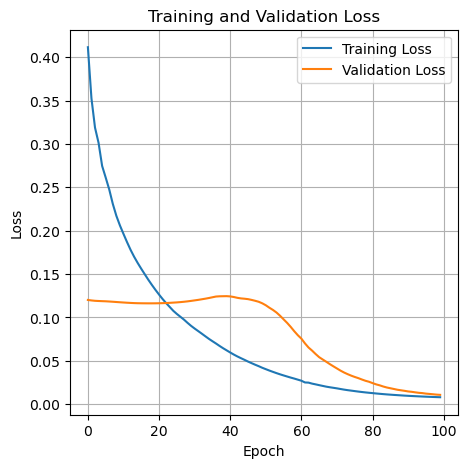

In [106]:
train_losses, val_losses = train_model(model, trainloader, valloader, 
                        loss_func=loss_function, optimizer=optimizer,epochs=100)
plot_train_loss(train_losses, val_losses)

In [107]:
hands, features, evs = next(iter(fullloader))

In [108]:
model.eval()
with torch.no_grad():
    embeddings, ev_pred = model(features)
    embeddings = F.normalize(embeddings, p=2, dim=1)

## Prediction Error Analysis

In [109]:
squared_error = (ev_pred - evs) ** 2

In [110]:
error_df = pd.DataFrame(squared_error)
error_df.columns = ev_data.filter(regex='play').columns
error_df.index = hands

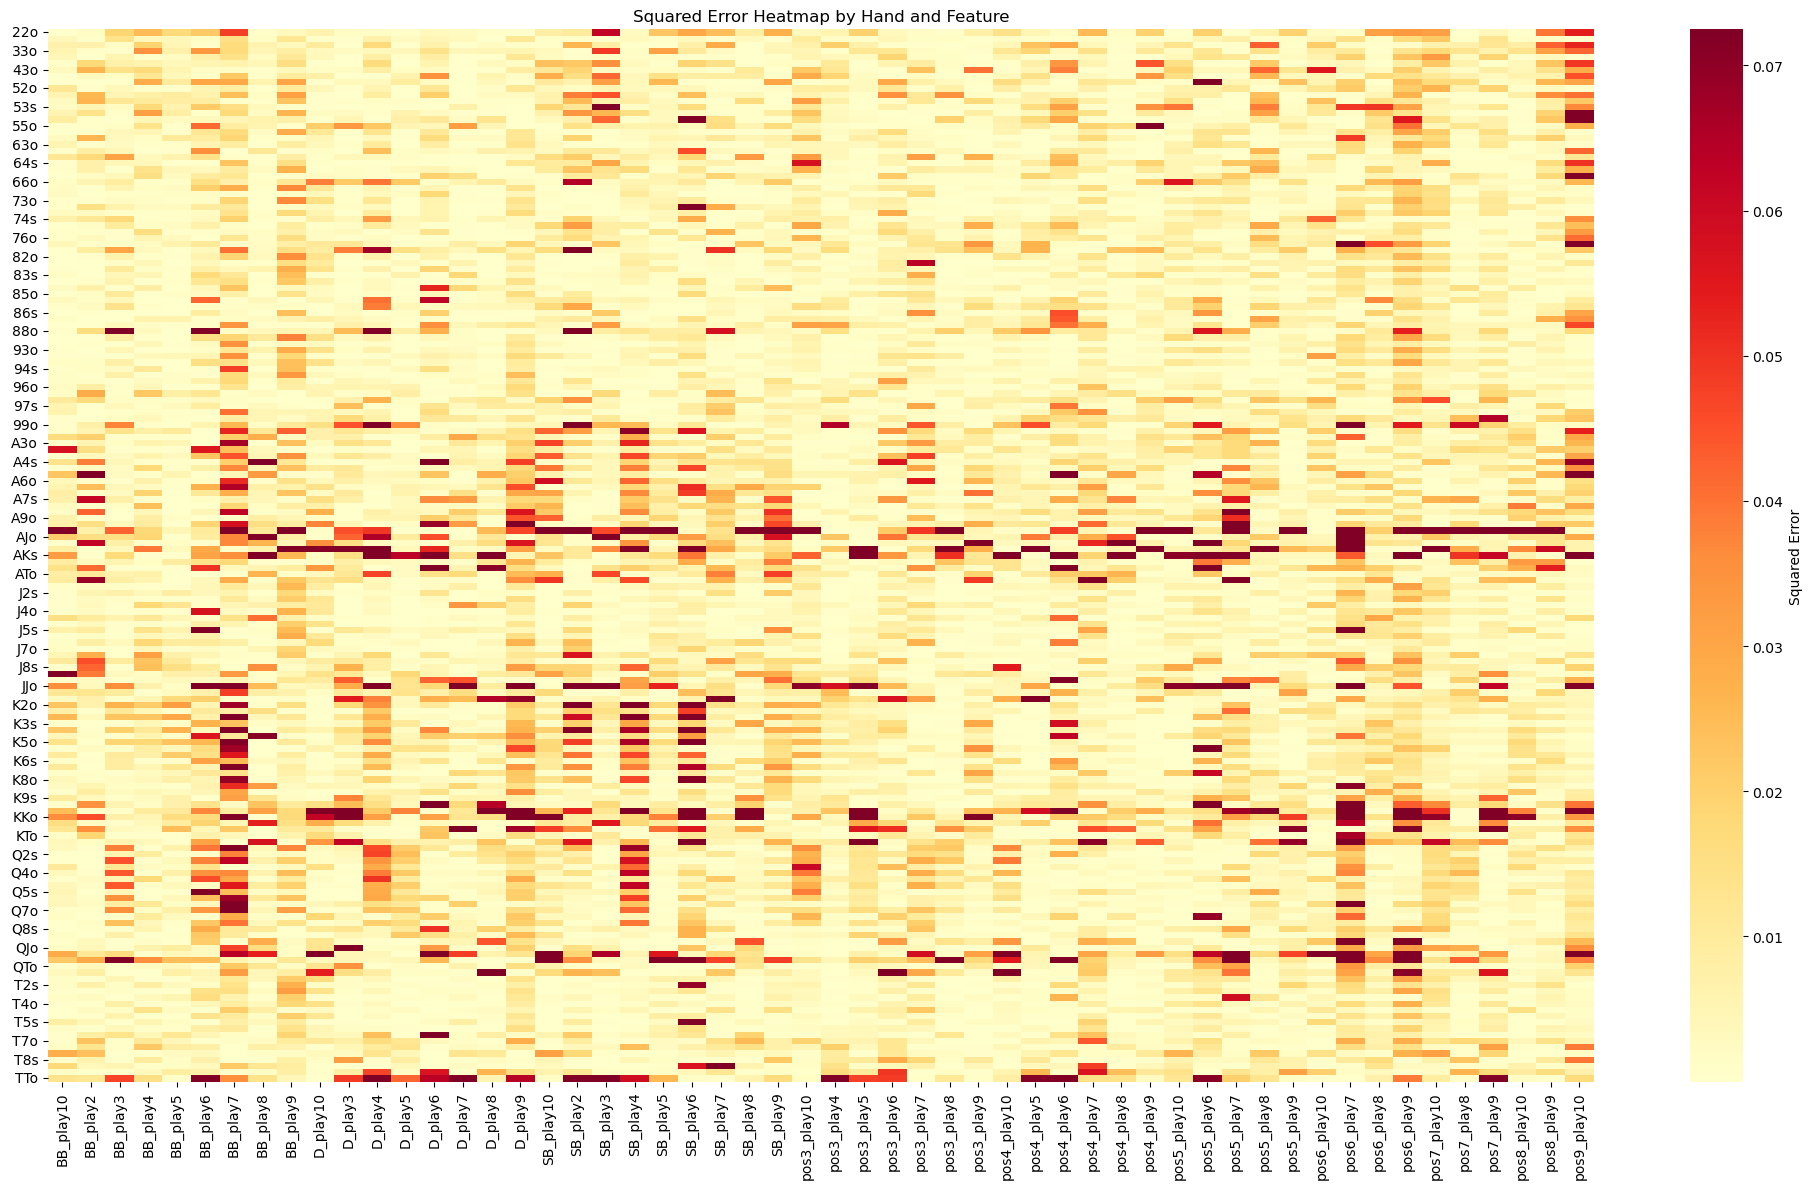

In [111]:
plt.figure(figsize=(20, 12))

ax = sns.heatmap(error_df, 
                 cmap='YlOrRd',
                 robust=True,
                 cbar_kws={'label': 'Squared Error'})

plt.title('Squared Error Heatmap by Hand and Feature')
plt.tight_layout()
plt.show()

## Embedding Analysis

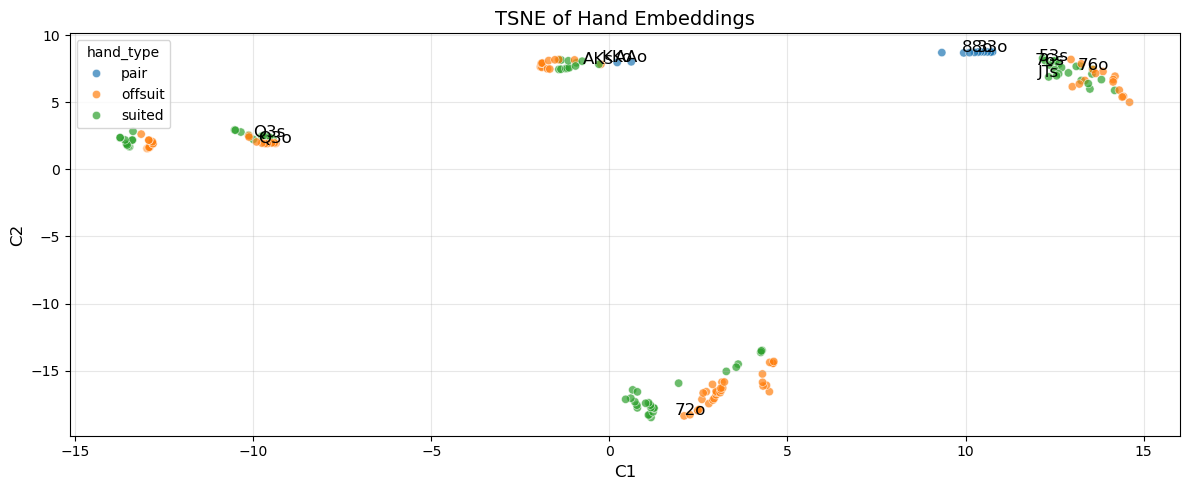

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  KKo (0.8192)  QQo (0.6970)  AKs (0.5938)  Q4o (-0.5096)   
1   KKo  AKs (0.8316)  AAo (0.8192)  AKo (0.8168)  63s (-0.5076)   
2   72o  82o (0.9990)  83o (0.9986)  92o (0.9969)  TTo (-0.7406)   
3   76s  64s (0.9965)  75s (0.9951)  53s (0.9951)  Q4o (-0.6845)   
4   76o  87o (0.9973)  65o (0.9925)  53o (0.9888)  Q9o (-0.5962)   
5   Q3s  Q4s (0.9990)  Q2s (0.9988)  Q8o (0.9963)  T8s (-0.7441)   
6   Q3o  Q4o (0.9997)  Q2o (0.9997)  Q5o (0.9985)  98s (-0.7308)   
7   88o  77o (0.9984)  99o (0.9963)  66o (0.9934)  J2s (-0.7457)   
8   JTs  T9s (0.9950)  98s (0.9880)  87s (0.9800)  Q7o (-0.7577)   
9   33o  22o (0.9993)  44o (0.9988)  55o (0.9940)  92s (-0.6502)   
10  AKs  AKo (0.9935)  AJs (0.8717)  ATs (0.8657)  97o (-0.5391)   
11  53s  43s (0.9997)  65s (0.9970)  64s (0.9968)  Q2s (-0.6421)   

         bottom_2       bottom_3  
0   Q3o (-0.5153)  Q2o (-0.5198)  
1   74s (-0.5139)  32s (-0.5221)  
2   99o (-

In [112]:

similarity_df = analyze_embeddings(
    embeddings, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )


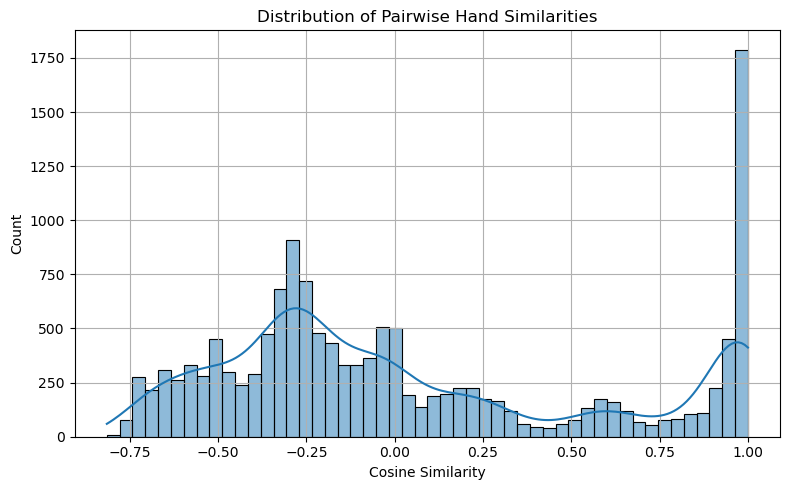

In [113]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)
all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
prob_data = prob_embeddings(embeddings, base_data)

In [115]:
prob_data[prob_data.attribute == 'suited_connector']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
78,suited_connector,0,0.940828,0.939759,1.000000,0.968944,0.923077
79,suited_connector,1,0.940828,1.000000,0.230769,0.375000,0.076923


In [116]:
prob_data[prob_data.attribute =='connector']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
72,connector,0,0.946746,0.958904,0.979021,0.968858,0.846154
73,connector,1,0.946746,0.869565,0.769231,0.816327,0.153846


In [117]:
prob_data[prob_data.attribute =='suited']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
0,suited,0,0.982249,1.000000,0.967033,0.983240,0.538462
1,suited,1,0.982249,0.962963,1.000000,0.981132,0.461538


In [ ]:
# save_model_and_embeddings(
#     embeddings,
#     'preflop_embeddings_predictive',
#     model,
#     "preflop_predictive_encoder_weights"
#     )